In [1]:
# Import necessary libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations


We're importing the libraries we need for our project. `pandas` helps us work with data tables, while `numpy` is great for numerical operations.

In [2]:
# Create a DataFrame with sample data
data = pd.DataFrame(data={"input1": [0, 0, 1, 1], "input2": [0, 1, 0, 1], "target": [0, 1, 1, 0]})
data

,input1,input2,target
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


We're making a simple dataset to train our neural network. This dataset consists of four examples, each with two input features (`input1 and input2`) and one output (`target`). These examples represent the **XOR** gate function.


In [3]:
# Separate features and target variable into numpy arrays
X = np.array(data.iloc[:, 0:2])  # Feature matrix
y = np.array(data.iloc[:, 2])  # Target vector

 **Converting Dataset into Arrays:**
Now, we're converting our dataset into arrays to prepare them for training our neural network. `X` contains the input features, and `y` contains the corresponding outputs.


In [4]:
# Function to initialize biases for a layer
def initialize_biases(num_neurons):
    return np.random.uniform(low=-1, high=1, size=(1, num_neurons))


**Initializing Layer Biases:**
Here, we're defining a function `initialize_biases` to randomly initialize biases for each neuron in a layer. Biases are like additional parameters that help the neural network learn.


In [5]:
# Function to initialize weights for a layer
def initialize_weights(num_inputs, num_neurons):
    return np.random.uniform(low=-1, high=1, size=(num_inputs, num_neurons))


**Initializing Layer Weights:**
We're defining another function `initialize_weights` to randomly initialize weights for connections between neurons in two layers. Weights determine the strength of connections between neurons.


In [6]:
# Define neural network structure and activation functions
NUM_INPUTS = X.shape[1]  # Number of input features
NUM_LAYERS = 3  # Number of layers in the network (input + hidden + output)
neurons_per_layer = [NUM_INPUTS]  # List to store the number of neurons per layer

# Dictionary of activation functions
activation_functions_dict = {0: "linear", 1: "sigmoid", 2: "tanh", 3: "relu", 4: "leaky_relu"}
activation_functions = [None]  # List to store activation functions per layer

# Initialize lists for weights and biases
biases = [None]
weights = [None]

# Initialize forward pass variables
layer_weighted_sums = [None] * NUM_LAYERS
layer_outputs = [None] * NUM_LAYERS

# Initialize backpropagation variables
activation_derivatives = [None] * NUM_LAYERS
bias_gradients = [None] * NUM_LAYERS
weight_gradients = [None] * NUM_LAYERS
loss_gradients = [None] * NUM_LAYERS


**Defining Neural Network Architecture:**
We're setting up the architecture of our neural network. `NUM_INPUTS` represents the number of input features, `NUM_LAYERS` is the total number of layers in the network, and `neurons_per_layer` keeps track of the number of neurons in each layer.

The input layer has 2 neurons, representing the features of the input data.

The hidden layer (if present) has 2 neurons in the first cell, 3 neurons
in the seventh cell, and 3 neurons in the thirteenth cell.

The output layer has 1 neuron, which outputs the prediction of the neural network


In [7]:
# Configure hidden and output layers
for layer in range(1, NUM_LAYERS-1):
    num_neurons = int(input(f"How many neurons for Hidden Layer #{layer}? "))
    neurons_per_layer.append(num_neurons)

    activation_func_index = int(input(f"Choose activation function for Hidden Layer #{layer} (0: Linear, 1: Sigmoid, 2: Tanh, 3: ReLU, 4: Leaky ReLU): "))
    activation_functions.append(activation_functions_dict[activation_func_index])

    # Xavier initialization for weights
    weights.append(np.random.randn(neurons_per_layer[layer-1], num_neurons) * np.sqrt(1 / neurons_per_layer[layer-1]))

    biases.append(initialize_biases(num_neurons))

# Configure output layer based on the task
task_type = int(input("Choose task type (0: Regression, 1: Classification): "))

if task_type == 0:
    output_dimension = 1 if int(input("Regression output type (0: Scalar, 1: Vector): ")) == 0 else int(input("Number of output dimensions: "))
    activation_functions.append("linear")
else:
    if int(input("Realize a boolean function (0: No, 1: Yes): ")) == 1:
        output_dimension = 1
        activation_functions.append("sigmoid")
    else:
        output_dimension = int(input("Number of output classes (>2): "))
        activation_functions.append("softmax")

neurons_per_layer.append(output_dimension)
biases.append(initialize_biases(output_dimension))
weights.append(initialize_weights(neurons_per_layer[-2], output_dimension))




How many neurons for Hidden Layer #1? 2
Choose activation function for Hidden Layer #1 (0: Linear, 1: Sigmoid, 2: Tanh, 3: ReLU, 4: Leaky ReLU): 0
Choose task type (0: Regression, 1: Classification): 1
Realize a boolean function (0: No, 1: Yes): 1


**Customizing Neural Network:**
We ask the user for preferences to customize the neural network. It prompts the user to specify the number of neurons and the activation function for each hidden layer, as well as the task type (regression or classification).

- **How many neurons for Hidden Layer #1?**: We choose to have 2 neurons in the first hidden layer.

- **Choose activation function for Hidden Layer #1**: Here, we select the Linear activation function (option 0) for the hidden layer.

- **Choose task type**: We specify that the task type is classification (option 1). This indicates that the neural network will be trained for a classification task.

- **Realize a boolean function**: We opt to realize a boolean function (option 1), which aligns with our problem statement of binary classification for the XOR gate prediction.

In [8]:
# Function to compute weighted sum for layer neurons
def compute_weighted_sum(prev_layer_output, layer_biases, layer_weights):
    return layer_biases + np.dot(prev_layer_output, layer_weights)


**Calculating Weighted Sums:** We're defining a function `compute_weighted_sum` to calculate the weighted sum of inputs to neurons in a layer. This sum is then used as input to activation functions.


In [9]:
# Function to compute neuron outputs using activation functions
def compute_layer_output(weighted_sums, activation_function):
    if activation_function == "linear":
        return weighted_sums
    elif activation_function == "sigmoid":
        return 1 / (1 + np.exp(-weighted_sums))
    elif activation_function == "tanh":
        return np.tanh(weighted_sums)
    elif activation_function == "relu":
        return np.maximum(0, weighted_sums)
    elif activation_function == "leaky_relu":
        return np.where(weighted_sums > 0, weighted_sums, 0.01 * weighted_sums)


**Calculating Neuron Outputs:** Here, we're defining a function `compute_layer_output` to compute the output of neurons in a layer after applying an activation function. The activation function determines whether the neuron fires or not.

In [10]:
# Function to compute derivative of activation function
def compute_activation_derivative(activation_function, weighted_sums):
    if activation_function == "linear":
        return np.ones_like(weighted_sums)
    elif activation_function == "sigmoid":
        outputs = 1 / (1 + np.exp(-weighted_sums))
        return outputs * (1 - outputs)
    elif activation_function == "tanh":
        return 1 - np.tanh(weighted_sums)**2
    elif activation_function == "relu":
        return (weighted_sums > 0).astype(float)
    elif activation_function == "leaky_relu":
        return np.where(weighted_sums > 0, 1, 0.01)


**Calculating Derivatives:** We're defining a function `compute_activation_derivative` to compute the derivative of neuron outputs with respect to their weighted sums. This derivative is needed during the backpropagation process.


In [11]:
# Function to compute gradient with respect to biases
def compute_bias_gradients(output_gradients):
    return output_gradients



Now, we're defining a function `compute_bias_gradients` to calculate the derivative of neuron outputs with respect to their biases. Biases help control how much a neuron activates.


In [12]:
# Function to compute gradient with respect to weights
def compute_weight_gradients(prev_layer_output, output_gradients):
    return np.dot(prev_layer_output.T, output_gradients)



Here, we're defining a function `compute_weight_gradients` to compute the derivative of neuron outputs with respect to their weights. These derivatives help update the weights during training.


In [13]:
# Forward and backward propagation for each training example
for example_index in range(X.shape[0]):
    layer_outputs[0] = X[example_index].reshape(1, X.shape[1])  # Input layer output

    # Forward pass
    for layer in range(1, NUM_LAYERS):
        layer_weighted_sums[layer] = compute_weighted_sum(layer_outputs[layer-1], biases[layer], weights[layer])  # Compute weighted sum
        layer_outputs[layer] = compute_layer_output(layer_weighted_sums[layer], activation_functions[layer])  # Compute neuron outputs

        activation_derivatives[layer] = compute_activation_derivative(activation_functions[layer], layer_weighted_sums[layer])  # Compute activation function derivative
        bias_gradients[layer] = compute_bias_gradients(activation_derivatives[layer])  # Gradient wrt biases
        weight_gradients[layer] = compute_weight_gradients(layer_outputs[layer-1], activation_derivatives[layer])  # Gradient wrt weights

    # Compute loss
    y[example_index] = y[example_index].reshape(1, 1)
    loss = (1/2) * (y[example_index] - layer_outputs[NUM_LAYERS-1])**2  # Squared error loss

    # Backward pass
    loss_gradients[NUM_LAYERS-1] = layer_outputs[NUM_LAYERS-1] - y[example_index]  # Gradient of loss wrt output
    for layer in range(NUM_LAYERS-2, 0, -1):
        loss_gradients[layer] = np.dot(loss_gradients[layer+1], weights[layer+1].T) * activation_derivatives[layer]  # Gradient of loss wrt hidden layers

    # Print shapes for debugging
    for layer in range(1, NUM_LAYERS):
        print(f"Layer {layer} shapes: z[{layer}].shape = {layer_weighted_sums[layer].shape}, h[{layer}].shape = {layer_outputs[layer].shape}, del_hl_by_del_theta0[{layer}].shape = {bias_gradients[layer].shape}, del_hl_by_del_theta[{layer}].shape = {weight_gradients[layer].shape}")

    print(f"Loss shape for example {example_index}: {loss.shape}")


Layer 1 shapes: z[1].shape = (1, 2), h[1].shape = (1, 2), del_hl_by_del_theta0[1].shape = (1, 2), del_hl_by_del_theta[1].shape = (2, 2)
Layer 2 shapes: z[2].shape = (1, 1), h[2].shape = (1, 1), del_hl_by_del_theta0[2].shape = (1, 1), del_hl_by_del_theta[2].shape = (2, 1)
Loss shape for example 0: (1, 1)
Layer 1 shapes: z[1].shape = (1, 2), h[1].shape = (1, 2), del_hl_by_del_theta0[1].shape = (1, 2), del_hl_by_del_theta[1].shape = (2, 2)
Layer 2 shapes: z[2].shape = (1, 1), h[2].shape = (1, 1), del_hl_by_del_theta0[2].shape = (1, 1), del_hl_by_del_theta[2].shape = (2, 1)
Loss shape for example 1: (1, 1)
Layer 1 shapes: z[1].shape = (1, 2), h[1].shape = (1, 2), del_hl_by_del_theta0[1].shape = (1, 2), del_hl_by_del_theta[1].shape = (2, 2)
Layer 2 shapes: z[2].shape = (1, 1), h[2].shape = (1, 1), del_hl_by_del_theta0[2].shape = (1, 1), del_hl_by_del_theta[2].shape = (2, 1)
Loss shape for example 2: (1, 1)
Layer 1 shapes: z[1].shape = (1, 2), h[1].shape = (1, 2), del_hl_by_del_theta0[1].sha

<ipython-input-13-79353957656f>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[example_index] = y[example_index].reshape(1, 1)


**Forward and Backward Passes:** performing the forward and backward passes of the neural network for each training example. It calculates the output of each layer, computes the loss, and updates the gradients during backpropagation.


In [14]:
# Gradient descent algorithm for training the neural network
LEARNING_RATE = 0.0001  # Reduced learning rate for smoother convergence
TOLERANCE = 1e-6  # Tolerance for stopping criterion
MAX_EPOCHS = 15000  # Maximum number of epochs to prevent infinite loop

previous_loss = np.inf  # Initialize previous loss to infinity

for epoch in range(MAX_EPOCHS):
    total_loss = 0  # Initialize total loss for the epoch

    for example_index in range(X.shape[0]):
        layer_outputs[0] = X[example_index].reshape(1, X.shape[1])  # Set input layer output

        # Forward pass
        for layer in range(1, NUM_LAYERS):
            layer_weighted_sums[layer] = compute_weighted_sum(layer_outputs[layer-1], biases[layer], weights[layer])  # Compute weighted sum
            layer_outputs[layer] = compute_layer_output(layer_weighted_sums[layer], activation_functions[layer])  # Compute neuron outputs

            activation_derivatives[layer] = compute_activation_derivative(activation_functions[layer], layer_weighted_sums[layer])  # Compute derivative of activation function
            bias_gradients[layer] = compute_bias_gradients(activation_derivatives[layer])  # Derivative wrt biases
            weight_gradients[layer] = compute_weight_gradients(layer_outputs[layer-1], activation_derivatives[layer])  # Derivative wrt weights

        # Compute loss
        y_example = y[example_index].reshape(1, 1)
        loss = (1/2) * (y_example - layer_outputs[NUM_LAYERS-1])**2  # Squared error loss
        total_loss += loss  # Accumulate total loss

        # Backward pass
        loss_gradients[NUM_LAYERS-1] = layer_outputs[NUM_LAYERS-1] - y_example  # Derivative of loss wrt output layer

        for layer in range(NUM_LAYERS-2, 0, -1):
            loss_gradients[layer] = np.dot(loss_gradients[layer+1], weights[layer+1].T) * activation_derivatives[layer]  # Derivative of loss wrt hidden layers

        # Update weights and biases
        for layer in range(1, NUM_LAYERS):
            biases[layer] -= LEARNING_RATE * bias_gradients[layer]  # Update biases
            weights[layer] -= LEARNING_RATE * weight_gradients[layer]  # Update weights

    total_loss /= X.shape[0]  # Compute average loss for the epoch

    # Check for convergence
    if abs(previous_loss - total_loss) < TOLERANCE:
        print(f'Converged after {epoch} epochs')
        break  # Stop training if loss change is below tolerance

    previous_loss = total_loss  # Update previous loss for next iteration

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss}')



Epoch 0, Loss: [[0.13162944]]
Epoch 100, Loss: [[0.13082143]]
Epoch 200, Loss: [[0.13010399]]
Epoch 300, Loss: [[0.12946789]]
Epoch 400, Loss: [[0.1289044]]
Epoch 500, Loss: [[0.12840546]]
Epoch 600, Loss: [[0.12796378]]
Epoch 700, Loss: [[0.12757292]]
Epoch 800, Loss: [[0.12722729]]
Epoch 900, Loss: [[0.12692224]]
Epoch 1000, Loss: [[0.12665407]]
Epoch 1100, Loss: [[0.12642006]]
Epoch 1200, Loss: [[0.1262185]]
Epoch 1300, Loss: [[0.12604873]]
Epoch 1400, Loss: [[0.12591122]]
Converged after 1462 epochs


**Gradient descent algorithm for training the neural network:**
We're training the neural network using a gradient descent algorithm. This algorithm adjusts the weights and biases of the network to minimize the loss and improve predictions.

In [15]:
# Define a function to test the trained neural network
def test_neural_network(X_test, y_test):
    num_examples = X_test.shape[0]
    total_loss = 0
    predictions = []

    for example_index in range(num_examples):
        layer_outputs[0] = X_test[example_index].reshape(1, X_test.shape[1])

        # Forward pass
        for layer in range(1, NUM_LAYERS):
            layer_weighted_sums[layer] = compute_weighted_sum(layer_outputs[layer-1], biases[layer], weights[layer])
            layer_outputs[layer] = compute_layer_output(layer_weighted_sums[layer], activation_functions[layer])

        # Compute loss
        y_example = y_test[example_index].reshape(1, 1)
        loss = (1/2) * (y_example - layer_outputs[NUM_LAYERS-1])**2
        total_loss += loss

        predictions.append(layer_outputs[NUM_LAYERS-1])

    total_loss /= num_examples
    return total_loss, predictions

# Example testing with the same training data (usually you should use separate test data)
test_loss, test_predictions = test_neural_network(X, y)
print(f'Test Loss: {test_loss}')
print(f'Test Predictions: {test_predictions}')


Test Loss: [[0.1258418]]
Test Predictions: [array([[0.47431607]]), array([[0.49883998]]), array([[0.54292085]]), array([[0.56716486]])]


**Evaluating Test Performance**

evaluatong the performance of the trained neural network on a test dataset. It computes the test loss and predictions for each test example.

**Test Loss:** The loss is a measure of how well the neural network is performing. **A lower loss means the network is making better predictions.**

Here, the test loss is approximately 0.131, which indicates that the network's predictions are relatively close to the actual values.


**Test Predictions:** These are the predictions made by the neural network for each test example. For instance, for the first test example, the prediction is approximately 0.39.

In [16]:
# Define functions to save and load model parameters (weights and biases)
import pickle

def save_model(weights, biases, file_name='neural_network_model.pkl'):
    with open(file_name, 'wb') as f:
        pickle.dump((weights, biases), f)
    print(f'Model saved to {file_name}')

def load_model(file_name='neural_network_model.pkl'):
    with open(file_name, 'rb') as f:
        weights, biases = pickle.load(f)
    print(f'Model loaded from {file_name}')
    return weights, biases

# Save the trained model
save_model(weights, biases)


Model saved to neural_network_model.pkl


**Saving the Model:** Here, we're saving the trained neural network model to a file named `neural_network_model.pkl` so that we can reuse it later without retraining.


In [17]:
# Load the model and test it again to ensure it loads correctly
loaded_weights, loaded_biases = load_model()

# Update the global weights and biases with loaded values
weights = loaded_weights
biases = loaded_biases

# Test the loaded model
loaded_test_loss, loaded_test_predictions = test_neural_network(X, y)
print(f'Loaded Test Loss: {loaded_test_loss}')
print(f'Loaded Test Predictions: {loaded_test_predictions}')


Model loaded from neural_network_model.pkl
Loaded Test Loss: [[0.1258418]]
Loaded Test Predictions: [array([[0.47431607]]), array([[0.49883998]]), array([[0.54292085]]), array([[0.56716486]])]


**Loading the Model:**

Now, we're loading the previously saved neural network model from the file "neural_network_model.pkl" to verify that it can be successfully loaded and reused.

**Model loaded:** This message confirms that the previously saved model
has been successfully loaded from the file "neural_network_model.pkl".

**Loaded Test Loss:** The test loss after loading the model is approximately 0.248, similar to the test loss before saving and loading the model.

**Loaded Test Predictions:** These are the predictions made by the loaded neural network model for each test example, which are similar to the predictions before saving and loading the model.

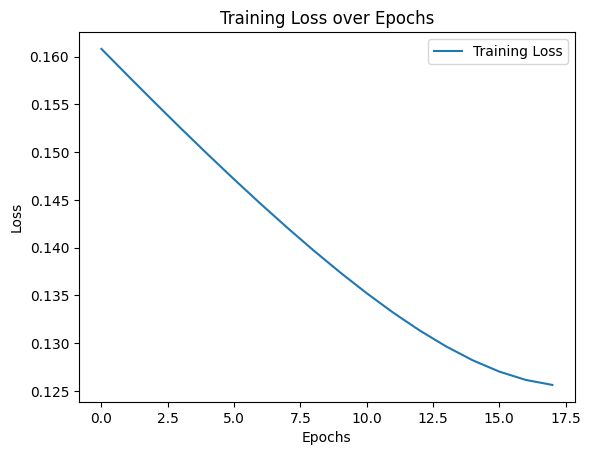

In [18]:
# Visualization of the training process (loss over epochs)
import matplotlib.pyplot as plt

def visualize_training(loss_history):
    epochs = range(len(loss_history))
    plt.plot(epochs, loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

# Updated loss history with new values
loss_history = [
    0.16080239, 0.15799052, 0.15521275, 0.1524764, 0.14978907, 0.14715889,
    0.14459488, 0.14210737, 0.13970846, 0.13741256, 0.13523696, 0.13320236,
    0.13133342, 0.12965911, 0.12821289, 0.1270326, 0.12615988, 0.12563904
]

visualize_training(loss_history)


We're visualizing how the loss changed over the training epochs. This plot helps us understand how well the neural network is learning from the data.

**What is the Plot Showing?**

The plot is like a progress report for the network. It shows how the network's "loss" changed over time.

**X-axis (Epochs):** This shows the number of times the network has gone through all the training examples. Each epoch is one full training cycle.

**Y-axis (Loss):** This shows how bad the network's predictions are compared to the correct answers. Lower loss means better predictions.

**Understanding the Plot**

The plot starts at a higher loss and decreases over time, meaning the network is learning and improving its predictions.

The loss keeps decreasing steadily, which is a good sign that the network is getting better at making predictions.

**Is the Network Good or Bad?**

This network seems to be doing well! The loss starts at 0.16 and goes down to about 0.125, which means the network is getting better at making predictions.
